## Installing important libraries for fine-tuning

In [ ]:
%%capture
!pip install --upgrade \
  "datasets>=2.18.0,<4" \
  "transformers>=4.41.0,<5" \
  "sentence-transformers>=3.3.0" \
  "accelerate>=0.27.2" \
  "seqeval>=1.2.2" \
  evaluate \
  scikit-learn \
  peft \
  huggingface_hub>=0.24.0 \



In [ ]:
!pip install   "setfit==1.1.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00


### mount google drive to save the model after fine-tuning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Login to huggingface hub 

In [ ]:
from google.colab import userdata
import wandb
from huggingface_hub import login

wandb.login(key=userdata.get('wandb'))
hf_token = userdata.get('Hf_token')

try:
    login(token=hf_token)
    print("Hugging Face Hub login successful!")
except Exception as e:
    print(f"Error during Hugging Face Hub login: {e}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yehiamagdy9 (yehiamagdy9-alexandria-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Hugging Face Hub login successful!


###### Imports

### Importing the necessary libraries for fine-tuning

In [ ]:
import torch
import torchvision
import torchaudio
import transformers
import accelerate
import huggingface_hub
import setfit
import evaluate
import peft
import datasets
import sklearn

print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'torchaudio version: {torchaudio.__version__}')
print(f'transformers version: {transformers.__version__}')
print(f'accelerate version: {accelerate.__version__}')
print(f'huggingface_hub version: {huggingface_hub.__version__}')
print(f'setfit version: {setfit.__version__}')
print(f'evaluate version: {evaluate.__version__}')
print(f'peft version: {peft.__version__}')
print(f'datasets version: {datasets.__version__}')
print(f'sklearn version: {sklearn.__version__}')

# Verify CUDA for torch
print(f'torch cuda available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'torch cuda version: {torch.version.cuda}')

torch version: 2.9.0+cu128
torchvision version: 0.24.0+cu128
torchaudio version: 2.9.0+cu128
transformers version: 4.57.6
accelerate version: 1.12.0
huggingface_hub version: 0.36.2
setfit version: 1.1.3
evaluate version: 0.4.6
peft version: 0.18.1
datasets version: 3.6.0
sklearn version: 1.8.0
torch cuda available: True
torch cuda version: 12.8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
from setfit import SetFitModel, SetFitTrainer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from datasets import Dataset, DatasetDict
from datasets import load_dataset
import pandas as pd

### Loading dataset from huggingface


In [ ]:
class StoryDatasetLoader:
    def __init__(self, dataset_name="FareedKhan/1k_stories_100_genre", columns=None):
        if columns is None:
            columns = ["id", "title", "story", "genre"]
        self.dataset_name = dataset_name
        self.columns = columns
        self.df = pd.DataFrame()
        self.documents = []
        self.chunked_documents = []

    def load_dataset(self, split="train"):
        """Load dataset from Hugging Face and convert to pandas DataFrame."""
        ds = load_dataset(self.dataset_name)
        self.df = ds[split].to_pandas()[self.columns]
        return self.df


In [ ]:
# Usage
loader = StoryDatasetLoader()
df = loader.load_dataset()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

1k_stories_100_genre.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### DataPreprocessing Techniques

##### Removing urls, special characters, whitespacese and lowercasing the stories

In [ ]:
import re

# clean_text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = text.strip()
    return text

df['text'] = df['story'].apply(clean_text)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Number of unique genres: 99

Number of stories per genre:
Historical Adventure: 20
Fantasy: 10
Science Fiction: 10
Mystery: 10
Thriller: 10
Historical Fiction: 10
Adventure: 10
Horror: 10
Comedy: 10
Crime: 10
Dystopian: 10
Cyberpunk: 10
Steampunk: 10
Post-Apocalyptic: 10
Fairy Tale: 10
Mythology: 10
Western: 10
War: 10
Espionage: 10
Superhero: 10
Slice of Life: 10
Magical Realism: 10
Alternate History: 10
Time Travel: 10
Paranormal: 10
Urban Fantasy: 10
Satire: 10
Political Drama: 10
Coming-of-Age: 10
Family Drama: 10
Space Opera: 10
Apocalyptic: 10
Noir: 10
Folklore: 10
Legal Drama: 10
Sports: 10
Humor: 10
Biographical: 10
Psychological Thriller: 10
Medical Drama: 10
Disaster: 10
Inspirational: 10
Gothic: 10
Experimental: 10
Artistic Drama: 10
Animal Fiction: 10
Environmental: 10
Techno-Thriller: 10
Alternate Reality: 10
Utopian: 10
Mystery Comedy: 10
Historical Romance: 10
Space Western: 10
Hard Science Fiction: 10
Soft Science Fiction: 10
Survival: 10
Philosophical Fiction: 10
Antho

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


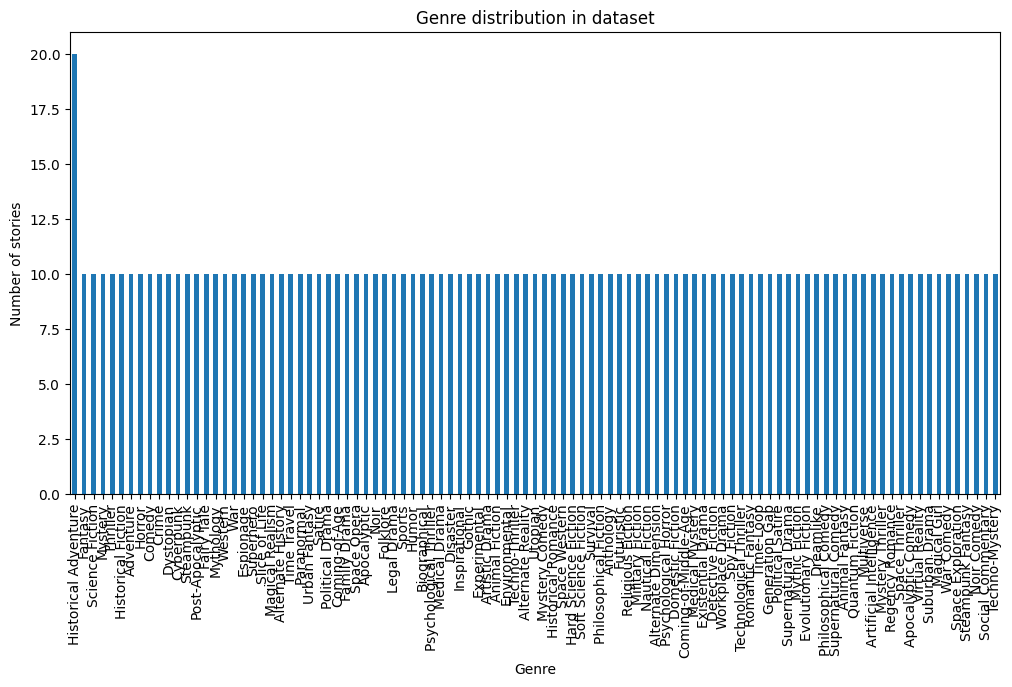

In [ ]:
# List unique genres
unique_genres = df['genre'].sort_values().unique()
num_classes = len(unique_genres)
print(f"Number of unique genres: {num_classes}\n")

# Print each genre and the number of stories in it
print("Number of stories per genre:")
genre_counts = df['genre'].value_counts()
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

#show missing or empty genres
missing_genres = df['genre'].isna().sum()
if missing_genres > 0:
    print(f"\nNumber of stories with missing genre: {missing_genres}")

# visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
genre_counts.plot(kind='bar')
plt.title("Genre distribution in dataset")
plt.xlabel("Genre")
plt.ylabel("Number of stories")
plt.show()


* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [ ]:
unique_genres = sorted(df['genre'].unique())  # sort for reproducibility
genre2id = {genre: idx for idx, genre in enumerate(unique_genres)}

# Map genre strings to integer IDs
df['label'] = df['genre'].map(genre2id)

# Verify
print(df[['genre', 'label']].head())
print(f"Number of unique integer labels: {df['label'].nunique()}")


                  genre  label
0       Science Fiction     69
1               Fantasy     29
2               Mystery     48
3  Historical Adventure     35
4              Thriller     89
Number of unique integer labels: 99


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
unique_genres = sorted(df['genre'].unique())  # sort alphabetically
for genre in unique_genres:
    print(genre)


Adventure
Alternate Dimension
Alternate History
Alternate Reality
Animal Fantasy
Animal Fiction
Anthology
Apocalyptic
Apocalyptic Comedy
Artificial Intelligence
Artistic Drama
Biographical
Comedy
Coming-of-Age
Coming-of-Middle-Age
Crime
Cyberpunk
Detective Fiction
Disaster
Domestic Fiction
Dreamlike
Dystopian
Environmental
Espionage
Evolutionary Fiction
Existential Drama
Experimental
Fairy Tale
Family Drama
Fantasy
Folklore
Futuristic
Generation Gap
Gothic
Hard Science Fiction
Historical Adventure
Historical Fiction
Historical Romance
Horror
Humor
Inspirational
Legal Drama
Magical Girl
Magical Realism
Medical Drama
Medical Mystery
Military Fiction
Multiverse
Mystery
Mystery Comedy
Mystery Thriller
Mythic Fiction
Mythology
Nautical Fiction
Noir
Noir Comedy
Paranormal
Philosophical Comedy
Philosophical Fiction
Political Drama
Political Satire
Post-Apocalyptic
Psychological Horror
Psychological Thriller
Quantum Fiction
Regency Romance
Religious Fiction
Romantic Fantasy
Satire
Science Fict

In [ ]:
id2genre = {idx: genre for genre, idx in genre2id.items()}
genre1 = id2genre[89]
genre1

'Thriller'

In [ ]:
for genre, idx in sorted(genre2id.items(), key=lambda x: x[1]):  # sort by ID
    print(f"{idx}: {genre}")

0: Adventure
1: Alternate Dimension
2: Alternate History
3: Alternate Reality
4: Animal Fantasy
5: Animal Fiction
6: Anthology
7: Apocalyptic
8: Apocalyptic Comedy
9: Artificial Intelligence
10: Artistic Drama
11: Biographical
12: Comedy
13: Coming-of-Age
14: Coming-of-Middle-Age
15: Crime
16: Cyberpunk
17: Detective Fiction
18: Disaster
19: Domestic Fiction
20: Dreamlike
21: Dystopian
22: Environmental
23: Espionage
24: Evolutionary Fiction
25: Existential Drama
26: Experimental
27: Fairy Tale
28: Family Drama
29: Fantasy
30: Folklore
31: Futuristic
32: Generation Gap
33: Gothic
34: Hard Science Fiction
35: Historical Adventure
36: Historical Fiction
37: Historical Romance
38: Horror
39: Humor
40: Inspirational
41: Legal Drama
42: Magical Girl
43: Magical Realism
44: Medical Drama
45: Medical Mystery
46: Military Fiction
47: Multiverse
48: Mystery
49: Mystery Comedy
50: Mystery Thriller
51: Mythic Fiction
52: Mythology
53: Nautical Fiction
54: Noir
55: Noir Comedy
56: Paranormal
57: P

In [ ]:
df = df[['text', 'label']]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Split into train/val/test for later comparison.
* For simplicity.
  -  80% train
  -  10% val
  -  10% test



In [ ]:
from sklearn.model_selection import train_test_split

# Split into train + temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split temp into val + test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 800, Val: 100, Test: 100


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [ ]:
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

hf_dataset = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

In [ ]:
print(hf_dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 100
    })
})


In [ ]:
from datasets import DatasetDict

# Function to remove the extra index column
def remove_index_column(dataset):
    if "__index_level_0__" in dataset.column_names:
        return dataset.remove_columns("__index_level_0__")
    return dataset

# Apply to each split in your DatasetDict
hf_dataset_clean = DatasetDict({
    split: remove_index_column(ds)
    for split, ds in hf_dataset.items()
})

# Verify
print(hf_dataset_clean)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})


### Acessing the dataset components

In [ ]:
# Access first 5 examples from the train split
train_split = hf_dataset_clean['train'][:5]  # This is a dict of lists
texts = train_split['text']
labels = train_split['label']

print("Train examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")

# Similarly for validation
val_split = hf_dataset_clean['validation'][:5]
texts = val_split['text']
labels = val_split['label']

print("\nValidation examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")

# And test
test_split = hf_dataset_clean['test'][:5]
texts = test_split['text']
labels = test_split['label']

print("\nTest examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")


Train examples:
1: Text: in the year 2234, earth was no longer inhabited by humans. it had been transformed into a vast, lush... Genre ID: 3
2: Text: once upon a time in a small town called "mundaneville," a mild-mannered man named mr. patterson live... Genre ID: 12
3: Text: once upon a time, in a small town named elmswood, lived a culinary genius named albert. he was not j... Genre ID: 83
4: Text: once upon a time in the mystical land of eldoria, where magic and wonderment were as real as the sun... Genre ID: 27
5: Text: in the heart of a bustling metropolis, the city that never sleeps, a new player had entered the game... Genre ID: 23

Validation examples:
1: Text: detective jack thompson was a man who had seen it all. his career in the city's police force had spa... Genre ID: 17
2: Text: chapter 1: the shadows of the city the sun had just begun to dip below the horizon, casting a golden... Genre ID: 54
3: Text: in the dimly lit underbelly of the city, a ragtag group of misfits assem

## Load sentence-transformers/paraphrase-mpnet-base-v2

### Model Name

In [ ]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"

In [ ]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(
    model_name,
    num_labels=len(hf_dataset["train"].unique("label"))
)

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
model

### Defining the model training arguments

In [ ]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=hf_dataset_clean["train"],
    eval_dataset=hf_dataset_clean["validation"],
    metric="accuracy",

    # TRAINING HYPERPARAMETERS
    num_iterations=10,   # how many contrastive pairs each example generates
    num_epochs=2,        # contrastive training epochs
    batch_size=8,       # contrastive batch size
    learning_rate=2e-5,   # contrastive learning rate
)

/tmp/ipython-input-3244788977.py:1: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


### Tracing the gpu usage and the time taken for training

In [ ]:
!nvidia-smi
!kill-9<PID>


Mon Feb 16 04:10:31 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             26W /   70W |     577MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import time

start_time = time.time()
trainer.train()
end_time = time.time()

total_time_sec = end_time - start_time
total_time_min = total_time_sec / 60

***** Running training *****
  Num unique pairs = 16000
  Batch size = 8
  Num epochs = 2
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:46.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.is_pinned() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:31.)
  return data.pin_memory(device)


Step,Training Loss
1,0.089100
50,0.140500
100,0.120800
150,0.099400
200,0.092200
250,0.088500
300,0.065800
350,0.073400
400,0.070400
450,0.063300


/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:46.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.is_pinned() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:31.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/jupyter_client/sessi

In [ ]:
trainer.evaluate()

***** Running evaluation *****
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'accuracy': 0.52}

### Loading the model for evaluation

In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/sbert_setfit"

trainer.model.save_pretrained(output_dir)


In [ ]:
from setfit import SetFitModel

output_dir = "/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/sbert_setfit"

# Load trained model
model = SetFitModel.from_pretrained(output_dir)


In [ ]:
X_test = hf_dataset_clean['test']['text']
y_test = hf_dataset_clean['test']['label']

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
y_pred

tensor([70, 41, 95, 26,  9, 73, 14, 44, 10, 12, 20, 34, 83, 34, 15, 53, 38,  7,
        49, 35, 59, 49, 27, 58,  1, 84, 65, 95, 96, 61, 28, 66, 19,  6, 39, 81,
        84, 15, 45, 21, 48, 33,  4, 74, 36, 16, 10, 80, 23,  5, 64, 25, 77, 51,
        62, 18, 89, 32, 75, 80, 22,  0, 98, 19, 27, 87, 89, 85,  3, 70, 11, 93,
        33, 80, 48, 31, 25, 23, 97, 49, 35, 91,  8, 88, 70, 68, 79, 69, 92,  6,
         0, 94, 86,  2, 69, 60, 67, 42, 67, 27])

### Measuring the performance of the model on the test set

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.58
Precision: 0.5083333333333333
Recall: 0.58
F1-score: 0.53

Classification Report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.50      1.00      0.67         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         1
          15       0.50      1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packag

### Plotting the confusion matrix for the test set

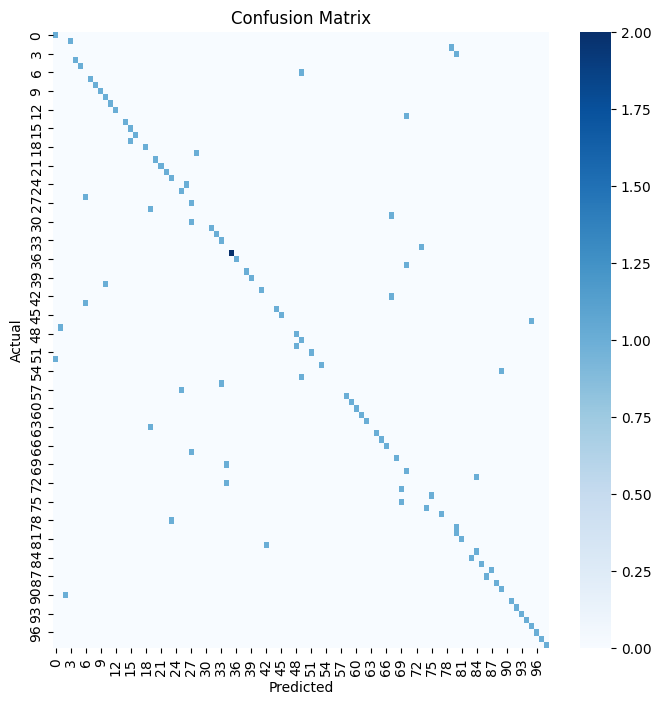

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


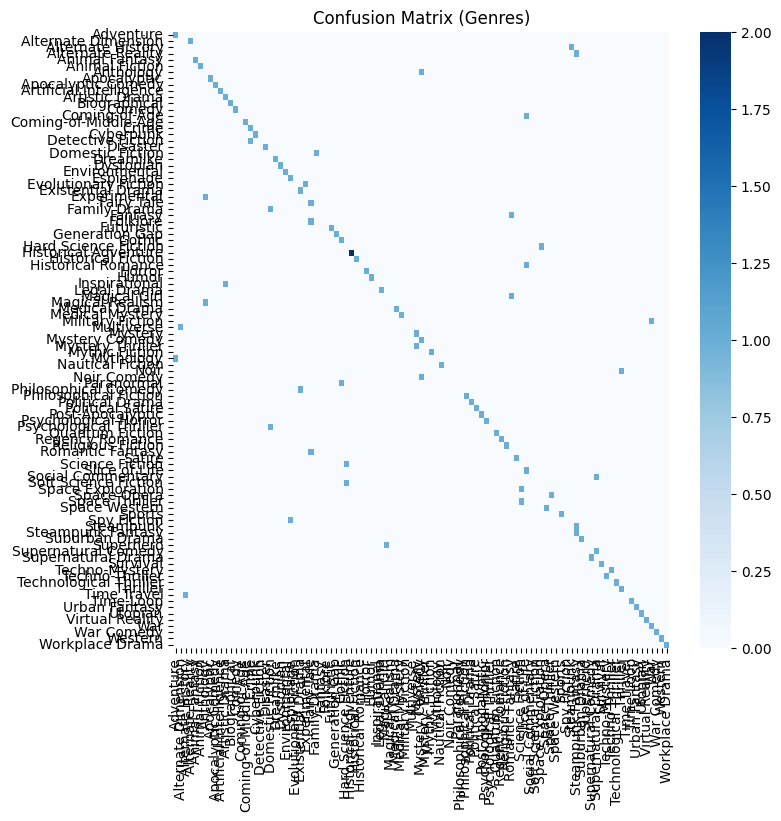

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
labels = [id2genre[i] for i in sorted(id2genre.keys())]

plt.figure(figsize=(8,8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Confusion Matrix (Genres)")
plt.show()


In [ ]:
f1_macro = f1_score(y_test, y_pred, average="macro")
print("Macro F1:", f1_macro)


Macro F1: 0.5252525252525253


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
input = """

In a small town, there lived an exceptional football player named Alex. Alex was known as "The Unbeatable Striker" for his incredible goal-scoring ability. His opponent """
predict = model.predict([input])[0]  # always pass list to SetFit
predict = int(predict)               # convert tensor → int
genre1 = id2genre[predict]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
genre1

'Sports'